# Model prediction of hazardous materials

<img src = "https://5.imimg.com/data5/GB/CR/IX/SELLER-41614352/handling-hazardous-material.jpg">




## 🖼️ Background

Once upon a time, in the early days of industrialization, there was little to no regulation on the use and handling of materials in the supply chain. As a result, hazardous materials were often used without proper safety precautions, putting workers and consumers at risk.
In the mid-20th century, public awareness of the dangers of hazardous materials began to grow, leading to the creation of regulations and safety standards. However, enforcing these standards was difficult, as there was no reliable way to quickly and accurately detect whether a material was hazardous or not.

This led to the development of various testing methods and technologies, such as chemical analysis and toxicity testing. However, these methods were often time-consuming and expensive, making them impractical for widespread use in the supply chain.

As technology advanced, new possibilities emerged. In the 21st century, machine learning and artificial intelligence algorithms became increasingly powerful and sophisticated. This opened up the possibility of using these algorithms to develop a faster, more efficient method of detecting hazardous materials in the supply chain.

The user, recognizing the potential of this technology, began working on developing an algorithm that could detect hazardous materials in real-time. They worked with experts in the field of chemistry and toxicology to gather data and train their algorithm to accurately identify hazardous materials.

After months of hard work, the user's algorithm was finally ready for testing. They integrated it into a supply chain monitoring system, which could automatically analyze incoming materials and alert workers if any hazardous materials were detected.

Thanks to the user's innovation and hard work, the supply chain became much safer, as workers and consumers could trust that the materials they were handling and using were not hazardous. This led to a significant reduction in workplace injuries and illnesses, and helped protect the health and safety of communities around the world.


## 📁 Dataset
For this challenge, you will have 2 CSV and a XSLX file:

state_code_to_name.csv
supply_chain_2012.csv (Train and Test)
cfs-2012-pum-file-users-guide-app-a-jun2015.xlsx
You will have to create a prediction model based on the HAZMAT variable found in the supply_chain_2012.csv

The dataset can be found in the XSLX file explained.

There is the following file to be downloaded:

data.zip: It is a table that relates the data with the fiiles described above. Download data.zip

## 📌 Task
The tasks are going to be based on answering and coding the following questions:

Create a prediction Model that can detect when a material in the Supply Chain is Hazardous and its type.


------------


## Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.display.float_format = '{:.0f}'.format
import geopandas as gpd
import matplotlib.gridspec as gridspec

## Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn import preprocessing

In [2]:

# to run in collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Cleaning

In [3]:
#df_raw = pd.read_csv('00 - Data/supply_chain_train.csv')
#state_code_to_name = pd.read_csv('00 - Data/state_code_to_name.csv')
#shapes = gpd.read_file('00 - Data/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')

df_raw = pd.read_csv('/content/drive/MyDrive/02 - Challenge 2/00 - Data/supply_chain_train.csv')
state_code_to_name = pd.read_csv('/content/drive/MyDrive/02 - Challenge 2/00 - Data/state_code_to_name.csv')

# I've added an additional file, in order to have the shapes of states
shapes = gpd.read_file('/content/drive/MyDrive/02 - Challenge 2/00 - Data/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')

In [4]:
shapes.head(2)

STATEFP   STATENS     AFFGEOID GEOID STUSPS      NAME LSAD         ALAND  \
0      24  01714934  0400000US24    24     MD  Maryland   00   25151100280   
1      19  01779785  0400000US19    19     IA      Iowa   00  144661267977   

       AWATER                                           geometry  
0  6979966958  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  1084180812  POLYGON ((-96.62187 42.77925, -96.57794 42.827...

### State Code to Name

In [5]:
display("Top 5 records\n",state_code_to_name.head(5),"Latest 5 records\n", state_code_to_name.tail(5))

'Top 5 records\n'

StateCode   StateName
0          1     Alabama
1          2      Alaska
2          4     Arizona
3          5    Arkansas
4          6  California

'Latest 5 records\n'

StateCode      StateName
46         51       Virginia
47         53     Washington
48         54  West Virginia
49         55      Wisconsin
50         56        Wyoming

## Train Dataset

In [6]:
# Top 5 rows of train dataset
display(df_raw.head(5), df_raw.columns)

train_idx  SHIPMT_ID  ORIG_STATE  ORIG_MA ORIG_CFS_AREA  DEST_STATE  \
0          0     703837          19    99999      19-99999          19   
1          1    2855307          37      268        37-268          37   
2          2    3712963          48    13140      48-13140          48   
3          3    1221124          41    99999      41-99999          41   
4          4    1956408          47      314        47-314          21   

   DEST_MA DEST_CFS_AREA  NAICS  QUARTER  ... MODE  SHIPMT_VALUE  SHIPMT_WGHT  \
0    99999      19-99999    325        2  ...    5          1868        67931   
1      268        37-268    212        1  ...    5           302        32638   
2      288        48-288    325        1  ...    6         90610       164745   
3    99999      41-99999   4247        4  ...    5          4503         3750   
4    99999      21-99999   4234        1  ...    5           108           11   

   SHIPMT_DIST_GC  SHIPMT_DIST_ROUTED  TEMP_CNTL_YN EXPORT_YN EXPORT_CNTRY  \
0             119                 162             N         N            N   
1              17                  21             N         N            N   
2              92                 132             N         N            N   
3               9                   9             N         N            N   
4              63                  85             N         N            N   

  WGT_FACTOR  HAZMAT  
0        157       1  
1         54       1  
2        465       0  
3       1568       1  
4        391       1  

[5 rows x 21 columns]

Index(['train_idx', 'SHIPMT_ID', 'ORIG_STATE', 'ORIG_MA', 'ORIG_CFS_AREA',
       'DEST_STATE', 'DEST_MA', 'DEST_CFS_AREA', 'NAICS', 'QUARTER', 'SCTG',
       'MODE', 'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_GC',
       'SHIPMT_DIST_ROUTED', 'TEMP_CNTL_YN', 'EXPORT_YN', 'EXPORT_CNTRY',
       'WGT_FACTOR', 'HAZMAT'],
      dtype='object')

In [7]:
# checking shape and nulls values
display("Shape: ",df_raw.shape,
        "Distribution: ",df_raw.describe().transpose(),
       "Null Values: ", df_raw.isnull().sum())

'Shape: '

(3638128, 21)

'Distribution: '

count    mean     std  min     25%     50%     75%  \
train_idx          3638128 1819064 1050237    0  909532 1819064 2728595   
SHIPMT_ID          3638128 2273763 1312943    2 1136599 2273330 3410918   
ORIG_STATE         3638128      29      15    0      17      29      42   
ORIG_MA            3638128   38430   46903    0     312     476   99999   
DEST_STATE         3638128      29      16    1      17      29      42   
DEST_MA            3638128   40363   47187  104     332     488   99999   
NAICS              3638128    7137   46718  212     326     339    4241   
QUARTER            3638128       2       1    1       1       2       3   
MODE               3638128       7       4    0       4       5      14   
SHIPMT_VALUE       3638128   18419 1131607    1     176     874    6015   
SHIPMT_WGHT        3638128   37256  955655    1      15     270    8068   
SHIPMT_DIST_GC     3638128     386     575    1      17     110     538   
SHIPMT_DIST_ROUTED 3638128     475     687    1      21     139     685   
WGT_FACTOR         3638128    2317   19371    0      93     290     994   
HAZMAT             3638128       1       0    0       1       1       1   

                         max  
train_idx            3638127  
SHIPMT_ID            4547661  
ORIG_STATE                56  
ORIG_MA                99999  
DEST_STATE                56  
DEST_MA                99999  
NAICS                 551114  
QUARTER                    4  
MODE                     101  
SHIPMT_VALUE       521277800  
SHIPMT_WGHT        277029600  
SHIPMT_DIST_GC          5174  
SHIPMT_DIST_ROUTED      6932  
WGT_FACTOR            975000  
HAZMAT                     2

'Null Values: '

train_idx             0
SHIPMT_ID             0
ORIG_STATE            0
ORIG_MA               0
ORIG_CFS_AREA         0
DEST_STATE            0
DEST_MA               0
DEST_CFS_AREA         0
NAICS                 0
QUARTER               0
SCTG                  0
MODE                  0
SHIPMT_VALUE          0
SHIPMT_WGHT           0
SHIPMT_DIST_GC        0
SHIPMT_DIST_ROUTED    0
TEMP_CNTL_YN          0
EXPORT_YN             0
EXPORT_CNTRY          0
WGT_FACTOR            0
HAZMAT                0
dtype: int64

>💡In general lines, the dataset seems to be a good baseline to start making some preliminar analysis, since in terms of data we will not have to deal with null values, or strange distributions.
The only thing we will do in this stage, is to use the states dataset in order to replace the states code in our base dataset.


In [8]:
df_raw['ORIG_STATE_NAME'] = df_raw['ORIG_STATE'].map(state_code_to_name.set_index('StateCode')['StateName'])
df_raw['DEST_STATE_NAME'] = df_raw['DEST_STATE'].map(state_code_to_name.set_index('StateCode')['StateName'])

---------

## Preliminar Analysis

We will define a function to plot summarized values into a geopandas map.
The function will take the following parameters:
- df_values: is the dataset in where we have the origin and destination data for materials
- shapes: geopandas dataframe
- focus: if we want to focus by destiny of materials (default option) or origin of materials
- cross_filter_state = to filter by source of materials (in case of Destiny option selected) or destiny of materials (in case of ORIGIN option selected)

In [9]:
def create_table(data,focus, cross_filter_state):
    # output list
    states = []

    pivot_data = data.pivot_table(index=['ORIG_STATE','ORIG_STATE_NAME','DEST_STATE','DEST_STATE_NAME'],values  = 'train_idx',aggfunc='count').reset_index()

    if focus == 'DES':
        state_list = list(pivot_data.DEST_STATE_NAME.unique() if cross_filter_state=='ALL' else cross_filter_state)
        pivot_data = pivot_data.loc[pivot_data.ORIG_STATE_NAME.isin(state_list)].pivot_table(index = ['DEST_STATE','DEST_STATE_NAME'], values='train_idx',aggfunc='sum').reset_index()
        pivot_data.rename(columns = {'DEST_STATE':'code','DEST_STATE_NAME':'state','train_idx':'total'}, inplace = True)
    else:
        state_list = list(pivot_data.ORIG_STATE_NAME.unique() if cross_filter_state =='ALL' else cross_filter_state)
        pivot_data = pivot_data.loc[pivot_data.DEST_STATE_NAME.isin(state_list)].pivot_table(index = ['ORIG_STATE','ORIG_STATE_NAME'], values='train_idx',aggfunc='sum').reset_index()
        pivot_data.rename(columns = {'ORIG_STATE':'code','ORIG_STATE_NAME':'state','train_idx':'total'}, inplace = True)

    return pivot_data


def plotting_map(df_values, shapes, title, cross_filter_state='ALL'):
    # converting the original dataset into a pivot table
    destiny_data = create_table(df_values, 'DES', cross_filter_state)
    origin_data = create_table(df_values,'ORI', cross_filter_state)

    # merging
    shapes['GEOID'] = shapes['GEOID'].astype(str).astype(int)

    merged_des = shapes.merge(destiny_data, left_on='GEOID', right_on='code', how='left')
    merged_or = shapes.merge(origin_data, left_on='GEOID', right_on='code', how='left')

    # set a variable that will call whatever column we want to visualize on the map
    variable = 'total'
    # set the range for the choropleth
    vmin, vmax = -160, -65

    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot the first map
    ax1 = axes[0]
    ax1.set_xlim(vmin, vmax)
    ax1.set_title(title + ' - Origin', size=20)
    merged_or.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)

    # Add annotations for 'total' values in Map 1
    for idx, row in merged_or.iterrows():
        annotation_text = row['STUSPS']
        ax1.annotate(text=annotation_text,
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     xytext=(3, 3),  # offset for the text
                     textcoords="offset points",
                     ha='center', va='center',
                     fontsize=8, color='black')

    # Plot the second map
    ax2 = axes[1]
    # Customize ax2 settings as needed
    ax2.set_xlim(vmin, vmax)
    ax2.set_title(title + ' - Destiny', size=20)
    merged_des.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax2, edgecolor='0.8', legend=True)

    # Add annotations for 'total' values in Map 2
    for idx, row in merged_des.iterrows():
        annotation_text = row['STUSPS']
        ax2.annotate(text=annotation_text,
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     xytext=(3, 3),  # offset for the text
                     textcoords="offset points",
                     ha='center', va='center',
                     fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

    # Display top tables separately
    print('TOP 5 Origins: ')
    display(merged_des.sort_values(by='total', ascending=False).head(5))

    print('TOP 5 DEST: ')
    display(merged_or.sort_values(by='total', ascending=False).head(5))

## Printing general operation

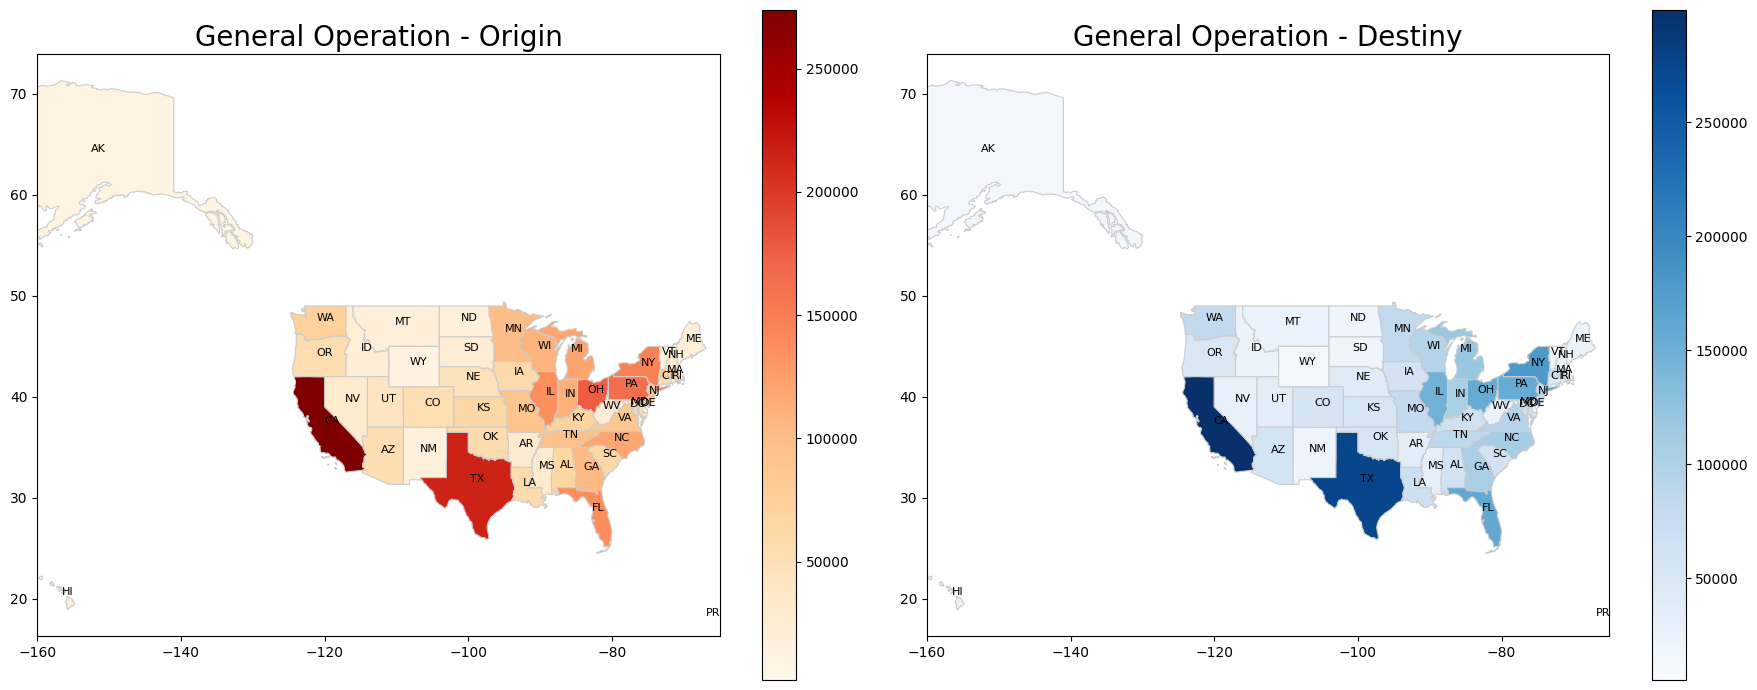

STATEFP   STATENS     AFFGEOID  GEOID STUSPS        NAME LSAD  \
12      06  01779778  0400000US06      6     CA  California   00   
11      48  01779801  0400000US48     48     TX       Texas   00   
21      36  01779796  0400000US36     36     NY    New York   00   
24      12  00294478  0400000US12     12     FL     Florida   00   
3       39  01085497  0400000US39     39     OH        Ohio   00   

           ALAND       AWATER  \
12  403503931312  20463871877   
11  676653171537  19006305260   
21  122049149763  19246994695   
24  138949136250  31361101223   
3   105828882568  10268850702   

                                             geometry  code       state  total  
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6  California 299367  
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48       Texas 274111  
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...    36    New York 178825  
24  MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ...    12     Florida 159655  
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...    39        Ohio 156498

STATEFP   STATENS     AFFGEOID  GEOID STUSPS          NAME LSAD  \
12      06  01779778  0400000US06      6     CA    California   00   
11      48  01779801  0400000US48     48     TX         Texas   00   
3       39  01085497  0400000US39     39     OH          Ohio   00   
4       42  01779798  0400000US42     42     PA  Pennsylvania   00   
21      36  01779796  0400000US36     36     NY      New York   00   

           ALAND       AWATER  \
12  403503931312  20463871877   
11  676653171537  19006305260   
3   105828882568  10268850702   
4   115884442321   3394589990   
21  122049149763  19246994695   

                                             geometry  code         state  \
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6    California   
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48         Texas   
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...    39          Ohio   
4   POLYGON ((-80.51989 40.90666, -80.51964 40.987...    42  Pennsylvania   
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...    36      New York   

    total  
12 273828  
11 214380  
3  176907  
4  164850  
21 147278

TOP 5 Origins: 
TOP 5 DEST: 


In [10]:
plotting_map(df_raw, shapes,'General Operation')

## We are going to deepdive into the different categories of Hazardous Materials

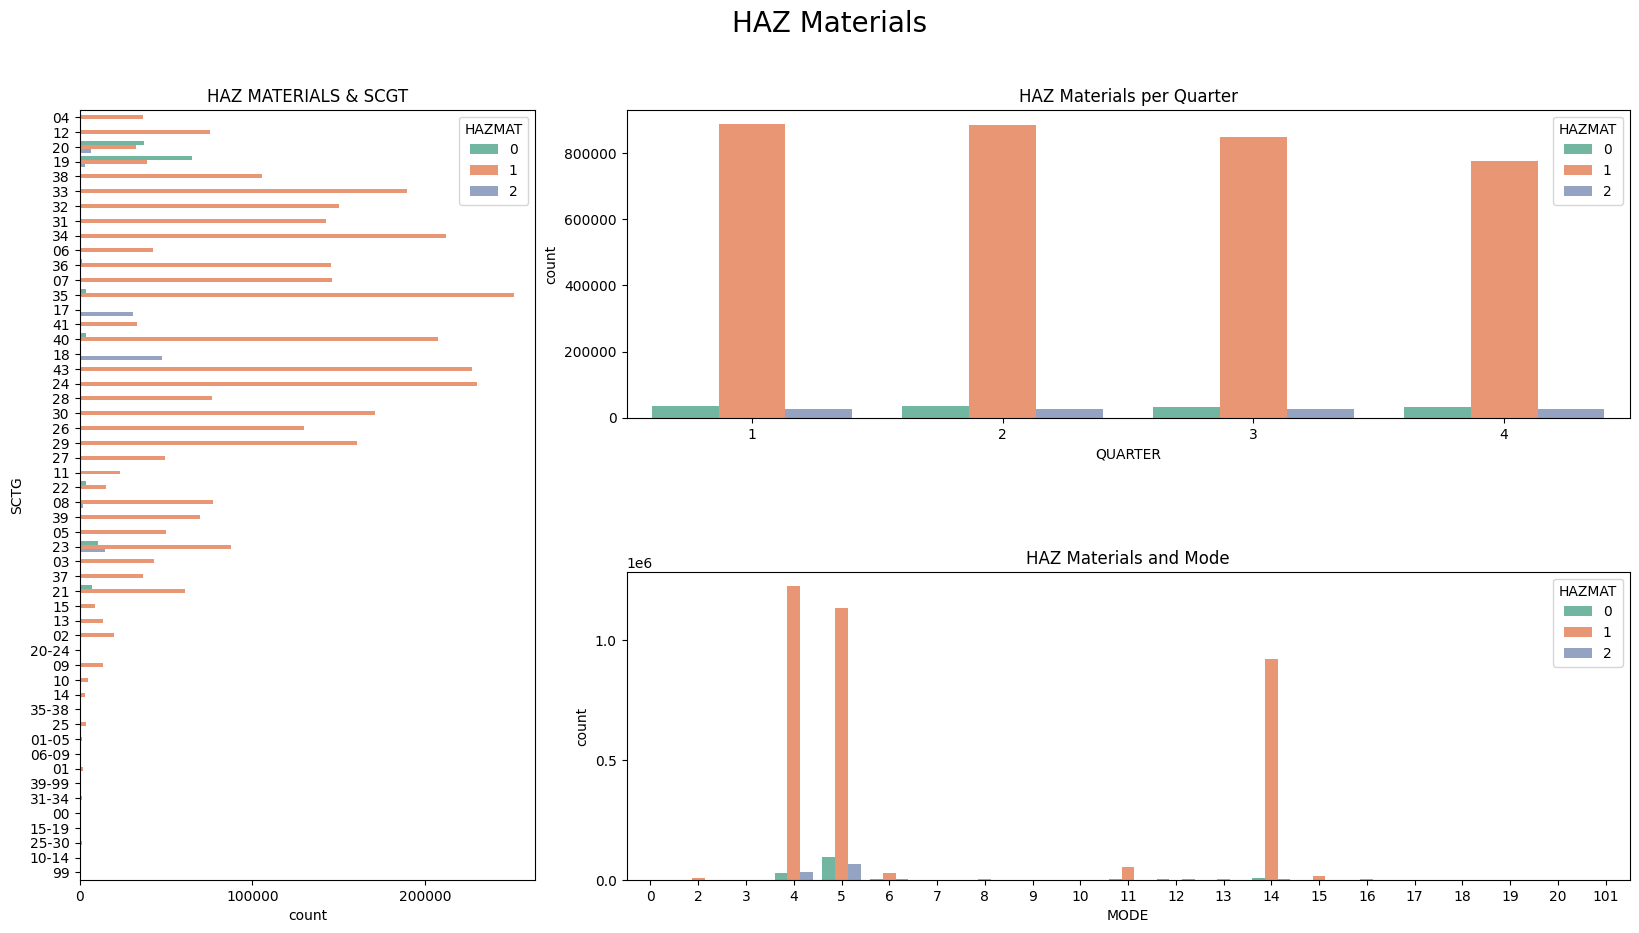

In [11]:
fig = plt.figure(1)
plt.suptitle('HAZ Materials',fontsize=20)
# set up subplot grid
gridspec.GridSpec(2,3)

# large subplot
plt.subplot2grid((2,3), (0,0), colspan=1, rowspan=2)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('HAZ MATERIALS & SCGT')
sns.countplot(data = df_raw, y = 'SCTG', palette='Set2',hue = 'HAZMAT')

# small subplot 1
plt.subplot2grid((2,3), (0,1),colspan=2)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('HAZ Materials per Quarter')
sns.countplot(data = df_raw, x = 'QUARTER', palette='Set2',hue = 'HAZMAT')

# small subplot 2
plt.subplot2grid((2,3), (1,1),colspan=2)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('HAZ Materials and Mode')
sns.countplot(data = df_raw, x = 'MODE',palette='Set2',hue = 'HAZMAT')


# fit subplots and save fig

fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()

We can see, that the predomminant HAZ material is the category 1, with a predominant activity thought MODE 4, 5 and 14.

On the other hand, if we analyze the rest of materials (0 and 1), they are more likely to appear in mode 4 and 5, and also SCTG 20 and 19 (for HAZ 0) and 17 and 18 (for HAZ 2)

In [12]:
# We will define auxiliar datasets, in order to filter by HAZ material

df_no_haz = df_raw.copy(deep=True).loc[df_raw.HAZMAT==0]
df_no_haz = df_no_haz.loc[df_no_haz.HAZMAT == 0]

df_haz_1 = df_raw.copy(deep=True)
df_haz_1 = df_haz_1.loc[df_haz_1.HAZMAT == 1]

df_haz_2 = df_raw.copy(deep=True)
df_haz_2 = df_haz_2.loc[df_haz_2.HAZMAT == 2]

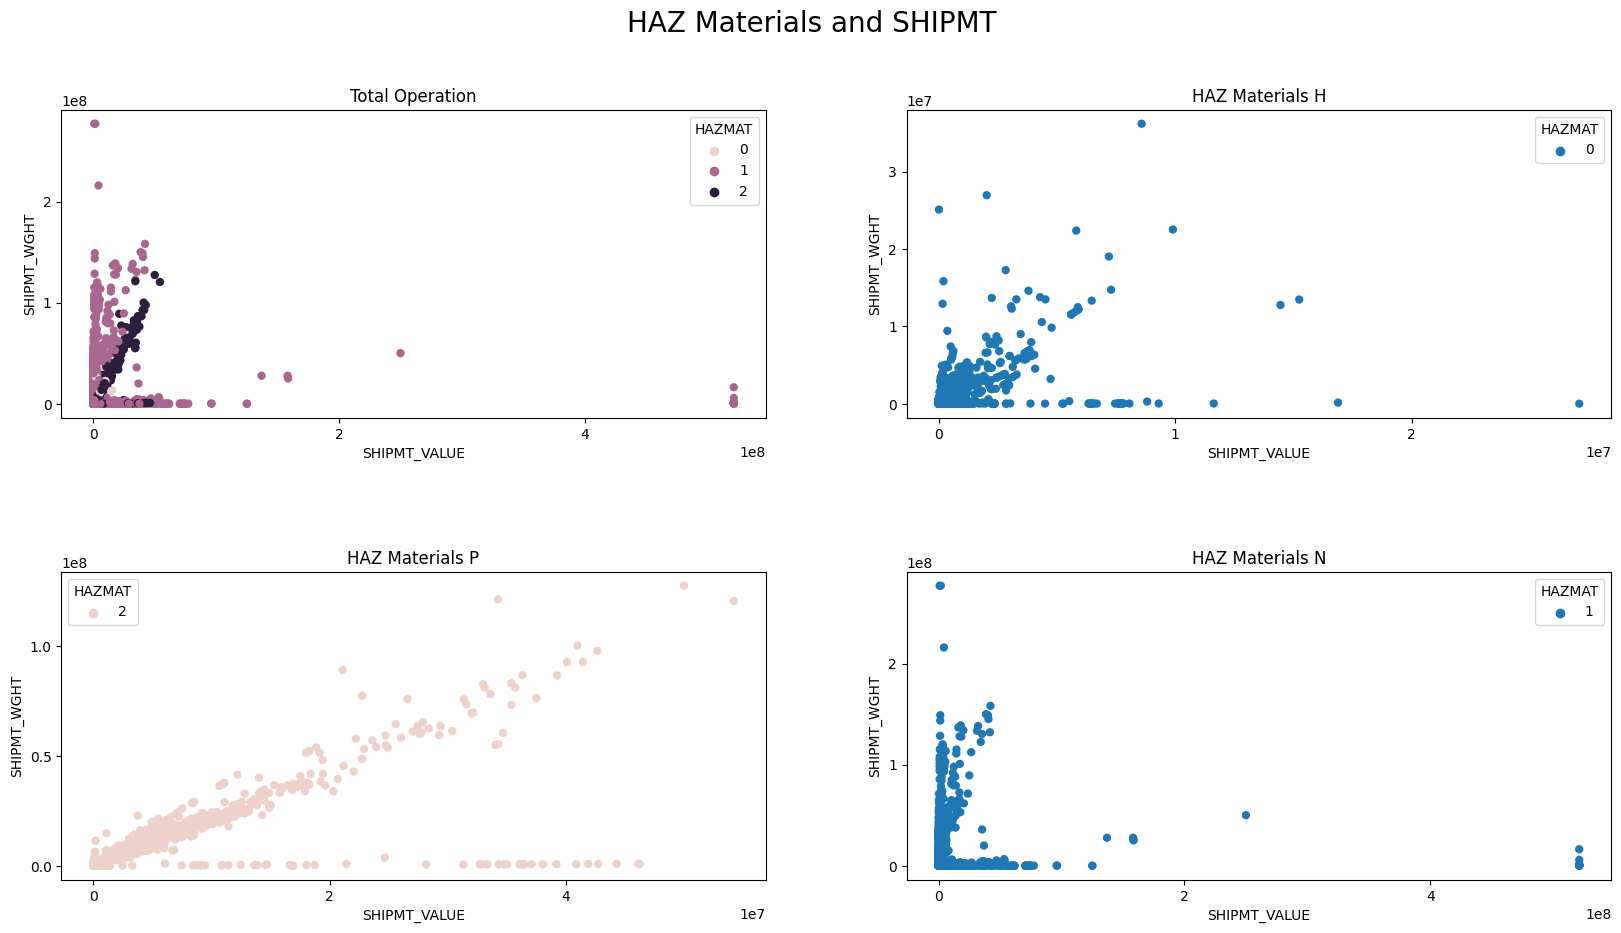

In [13]:
fig = plt.figure(1)
plt.suptitle('HAZ Materials and SHIPMT',fontsize=20)
# set up subplot grid
gridspec.GridSpec(2,2)

# large subplot
plt.subplot2grid((2,2), (0,0))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Total Operation')
sns.scatterplot(x="SHIPMT_VALUE", y="SHIPMT_WGHT",
                hue="HAZMAT",
                sizes=(1, 8), linewidth=0,
                data=df_raw)

# small subplot 1
plt.subplot2grid((2,2), (0,1))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('HAZ Materials H')
sns.scatterplot(x="SHIPMT_VALUE", y="SHIPMT_WGHT",
                hue="HAZMAT",
                sizes=(1, 8), linewidth=0,
                data=df_no_haz)

# small subplot 2
plt.subplot2grid((2,2), (1,1))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('HAZ Materials N')
sns.scatterplot(x="SHIPMT_VALUE", y="SHIPMT_WGHT",
                hue="HAZMAT",
                sizes=(1, 8), linewidth=0,
                data=df_haz_1)


plt.subplot2grid((2,2), (1,0))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('HAZ Materials P')
sns.scatterplot(x="SHIPMT_VALUE", y="SHIPMT_WGHT",
                hue="HAZMAT",
                sizes=(1, 8), linewidth=0,
                data=df_haz_2)

# fit subplots and save fig

fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()

We can notice a clear linear pattern, between SHIPMT_VALUE and SHIPMT_WGHT for HAZ MATERIALS P, when is not so clean for the rest of categories.

Text(0.5, 1.0, 'HAZMAT per State')

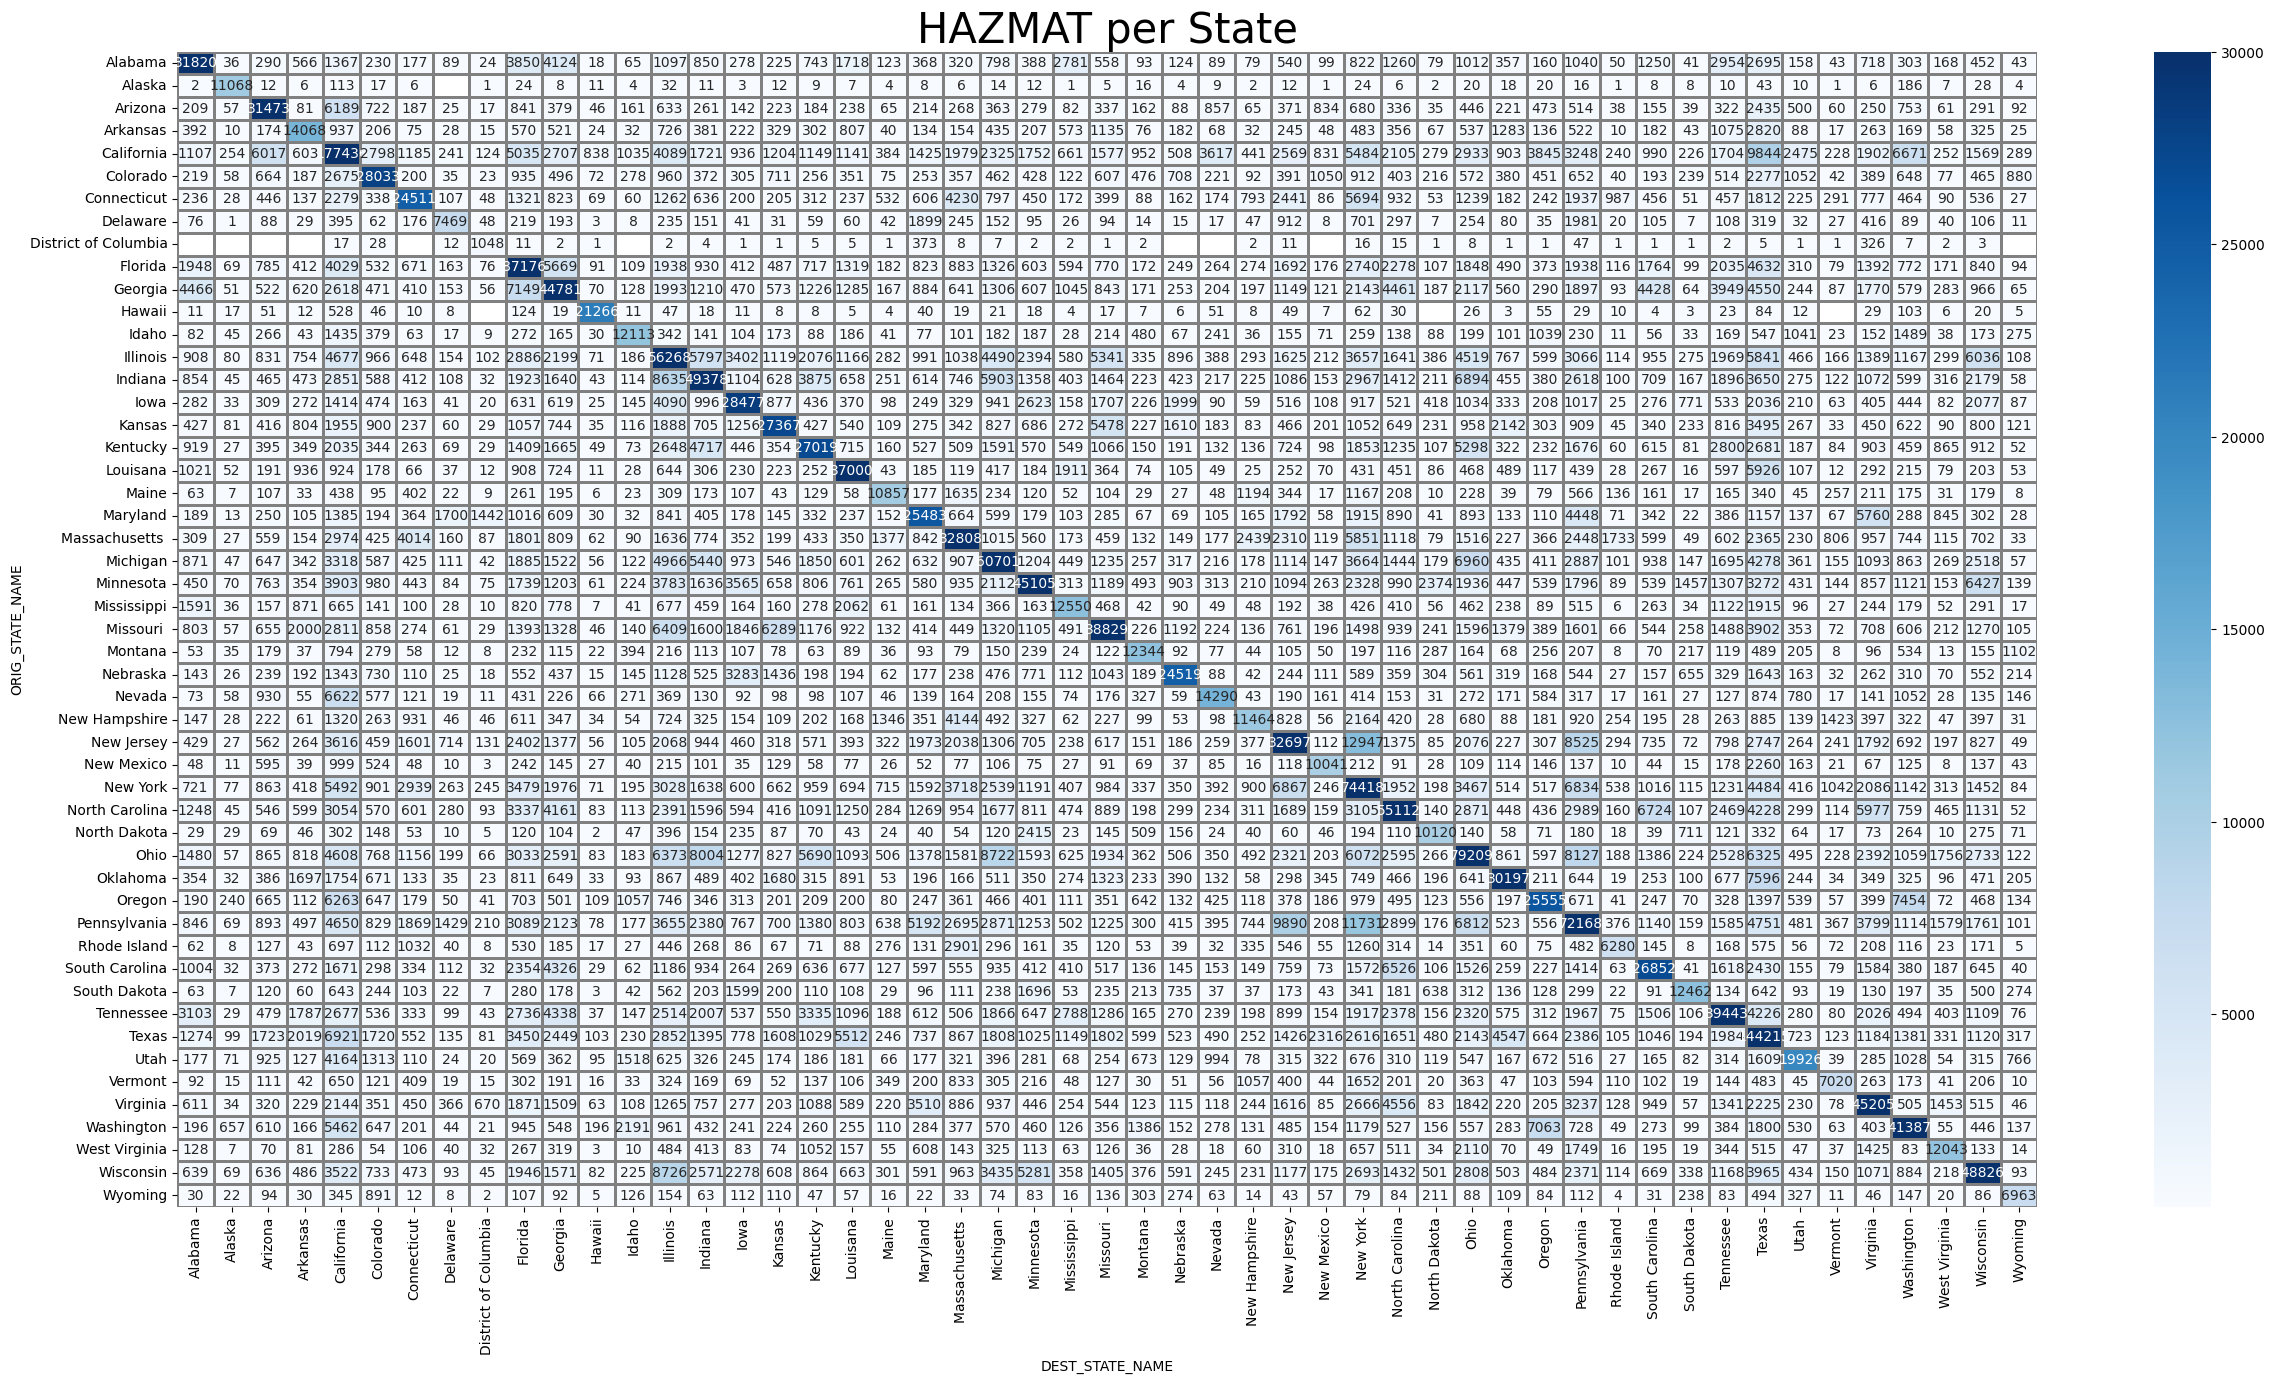

In [14]:
source_dest_table= df_raw.pivot_table(index='ORIG_STATE_NAME',values='train_idx', aggfunc='count', columns='DEST_STATE_NAME')
plt.figure(figsize=(30, 15))
sns.heatmap(source_dest_table, annot=True,  cmap='Blues', fmt='g', linecolor='grey',linewidths=1, vmax=30000)
plt.title('HAZMAT per State', size=30)

The diagonal line, suggest us that most of operation is internal within the same state.

## Printing Operation for Hazardous Materials H

Text(0.5, 1.0, 'HAZMAT H per State')

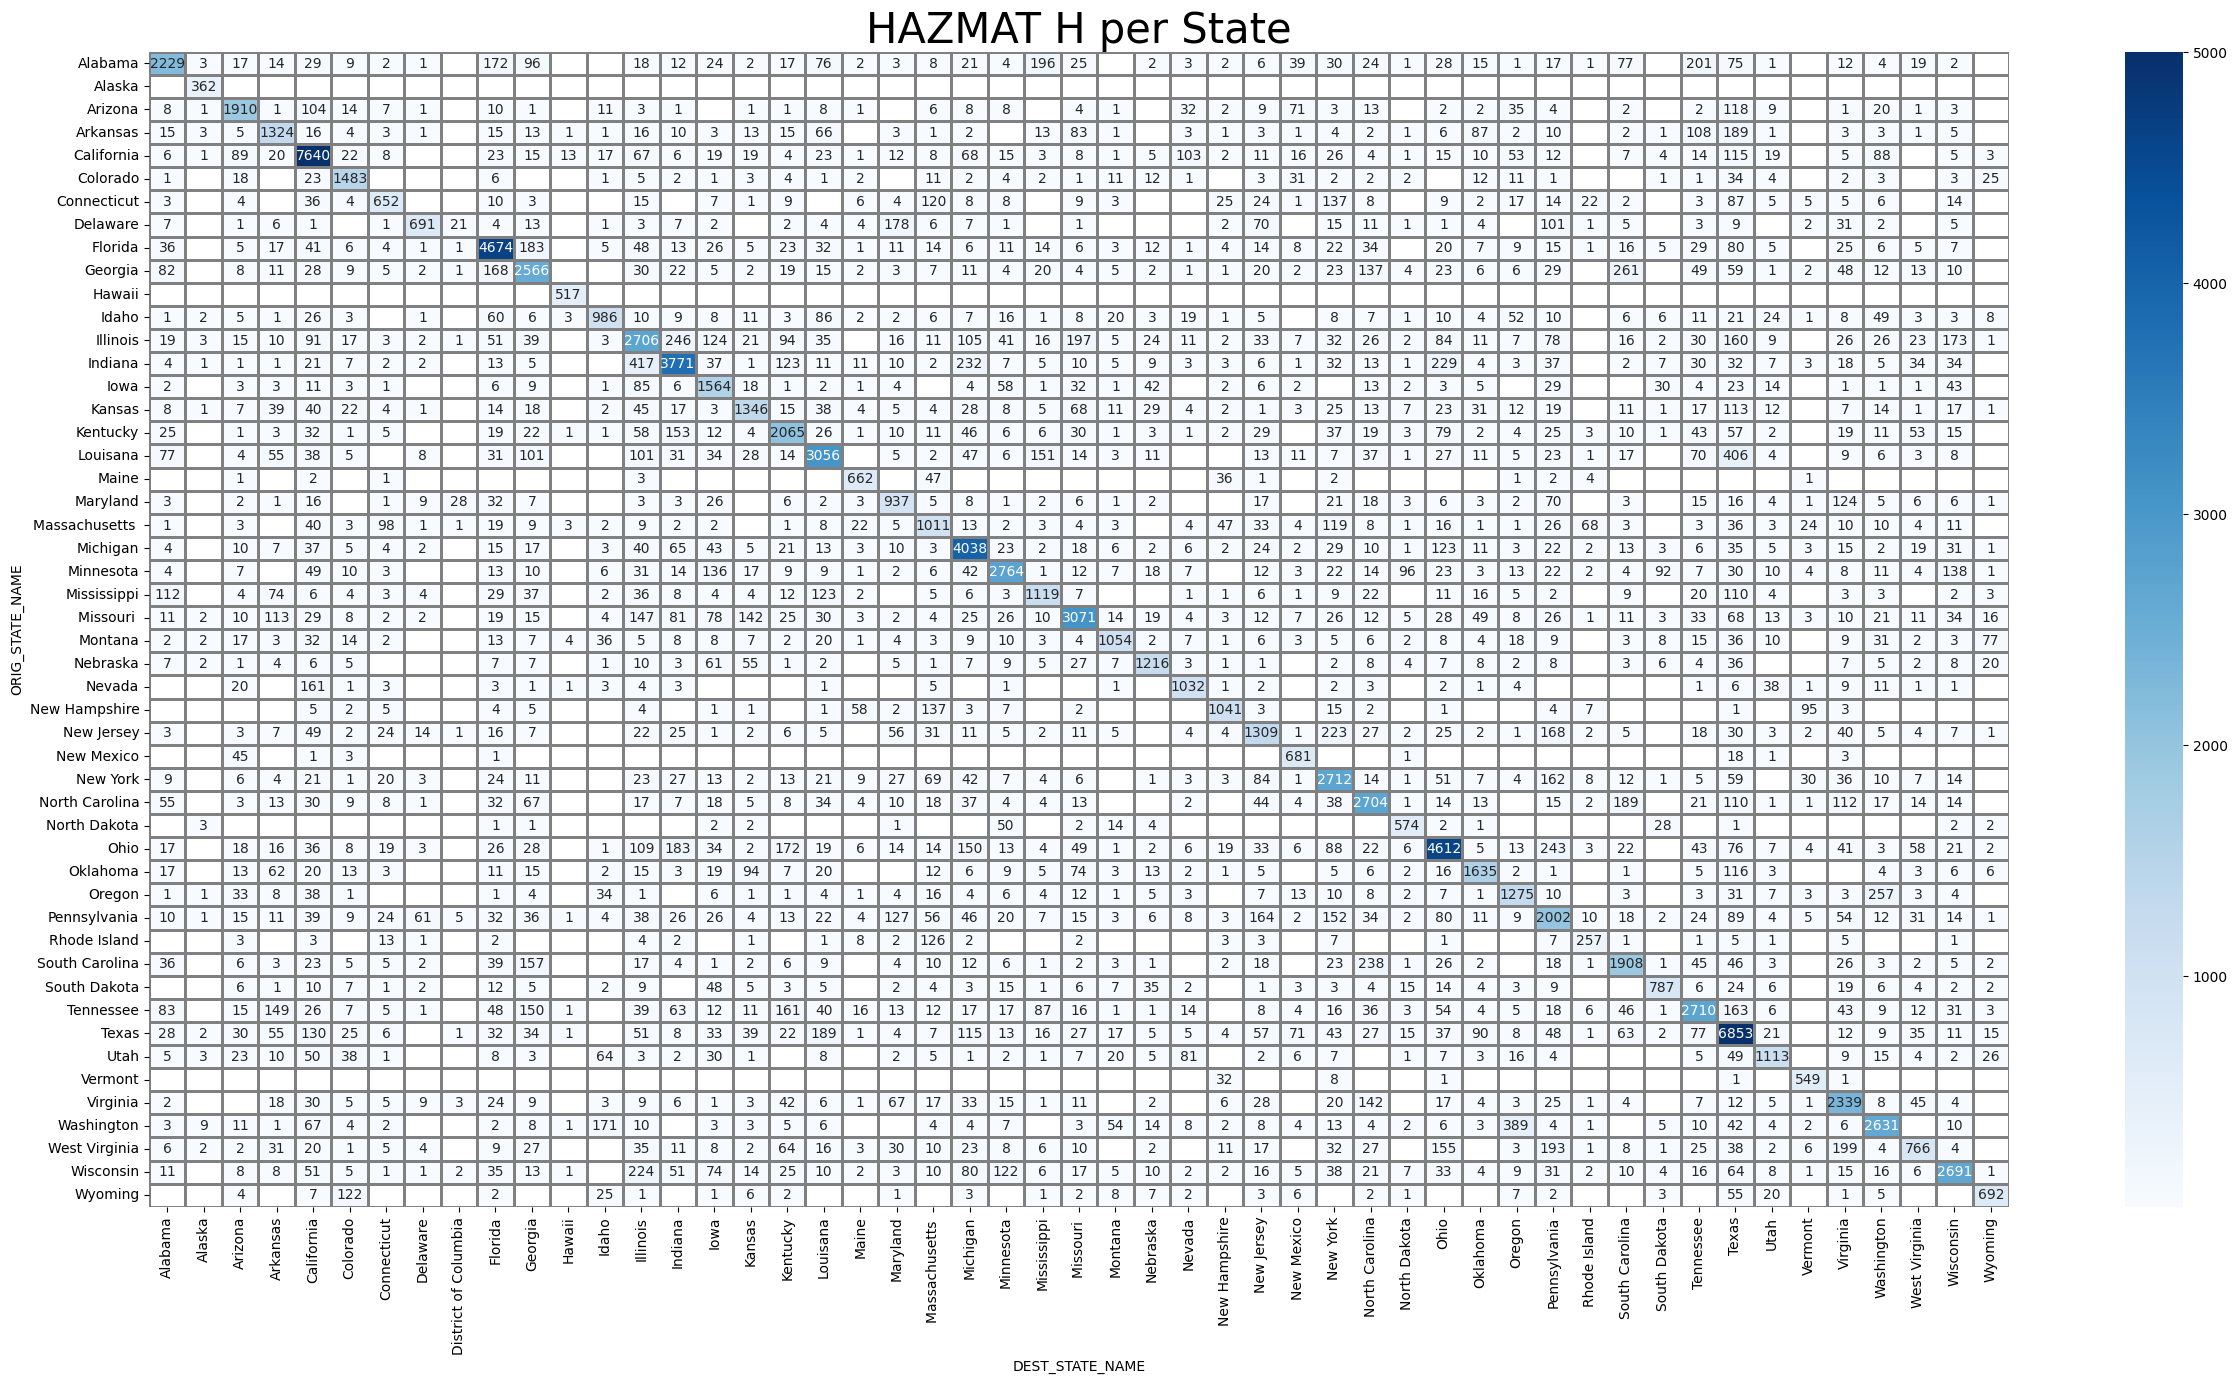

In [15]:

plt.figure(figsize=(30, 15))
sns.heatmap(df_no_haz.pivot_table(index='ORIG_STATE_NAME',values='train_idx', aggfunc='count', columns='DEST_STATE_NAME'), annot=True,  cmap='Blues', fmt='g', linecolor='grey',linewidths=1, vmax=5000)
plt.title('HAZMAT H per State', size=30)

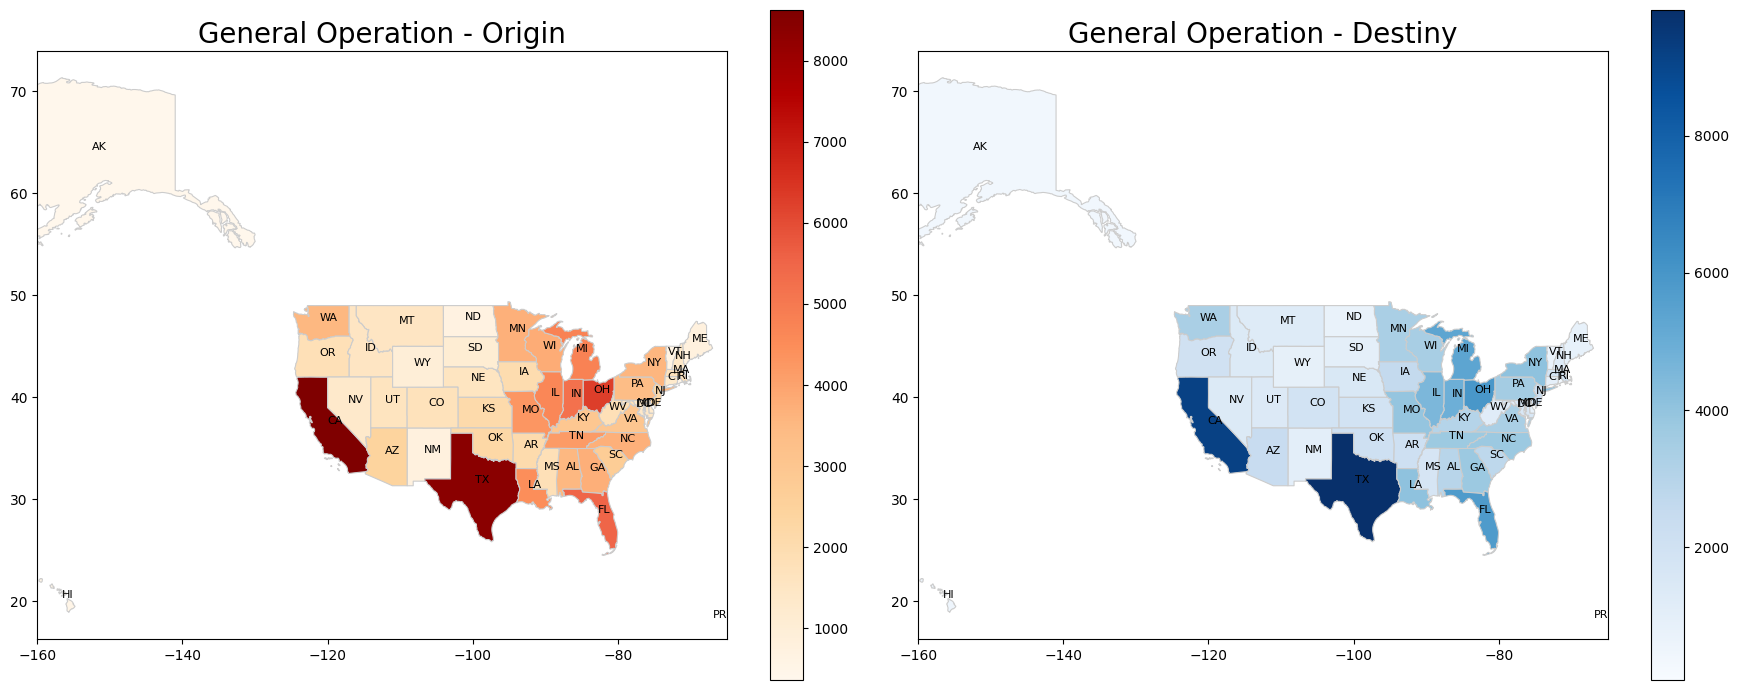

TOP 5 Origins: 


STATEFP   STATENS     AFFGEOID  GEOID STUSPS        NAME LSAD  \
11      48  01779801  0400000US48     48     TX       Texas   00   
12      06  01779778  0400000US06      6     CA  California   00   
3       39  01085497  0400000US39     39     OH        Ohio   00   
24      12  00294478  0400000US12     12     FL     Florida   00   
22      26  01779789  0400000US26     26     MI    Michigan   00   

           ALAND        AWATER  \
11  676653171537   19006305260   
12  403503931312   20463871877   
3   105828882568   10268850702   
24  138949136250   31361101223   
22  146600952990  103885855702   

                                             geometry  code       state  total  
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48       Texas   9834  
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6  California   9211  
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...    39        Ohio   5942  
24  MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ...    12     Florida   5787  
22  MULTIPOLYGON (((-84.61622 45.89447, -84.51789 ...    26    Michigan   5342

TOP 5 DEST: 


STATEFP   STATENS     AFFGEOID  GEOID STUSPS        NAME LSAD  \
12      06  01779778  0400000US06      6     CA  California   00   
11      48  01779801  0400000US48     48     TX       Texas   00   
3       39  01085497  0400000US39     39     OH        Ohio   00   
24      12  00294478  0400000US12     12     FL     Florida   00   
29      18  00448508  0400000US18     18     IN     Indiana   00   

           ALAND       AWATER  \
12  403503931312  20463871877   
11  676653171537  19006305260   
3   105828882568  10268850702   
24  138949136250  31361101223   
29   92789302676   1538002829   

                                             geometry  code       state  total  
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6  California   8626  
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48       Texas   8394  
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...    39        Ohio   6277  
24  MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ...    12     Florida   5510  
29  POLYGON ((-88.05947 37.86669, -88.04086 37.891...    18     Indiana   5212

In [16]:
plotting_map(df_no_haz, shapes,'General Operation')

## Printing Operation for Hazardous Materials N

Text(0.5, 1.0, 'HAZMAT N per State')

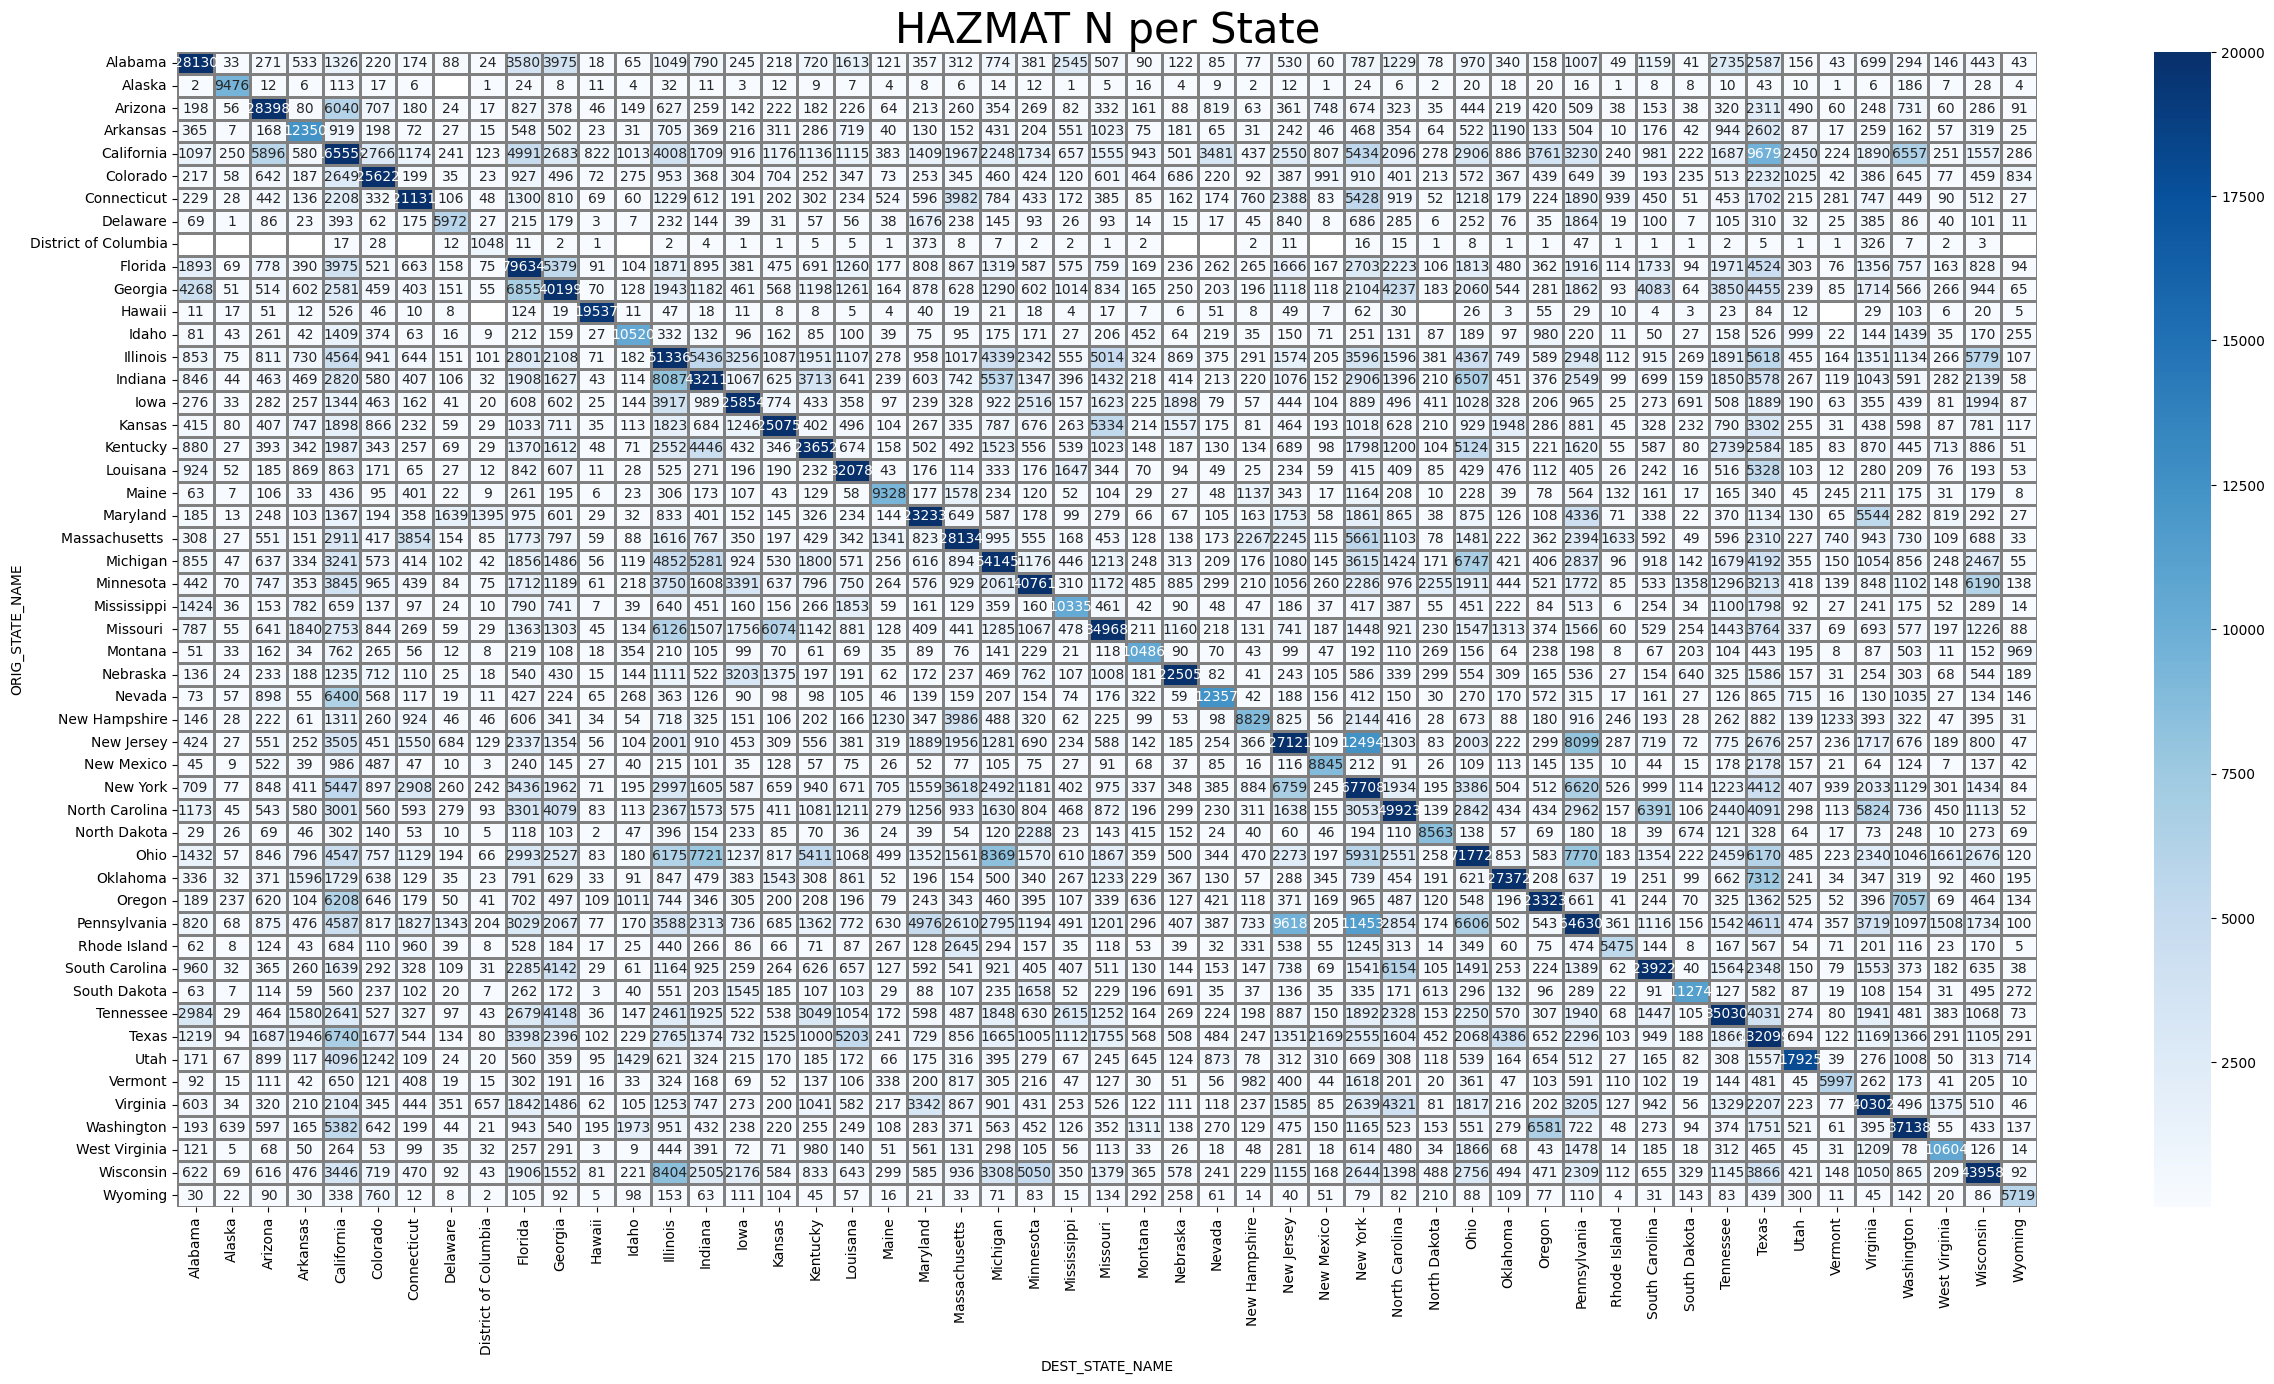

In [17]:

plt.figure(figsize=(30, 15))
sns.heatmap(df_haz_1.pivot_table(index='ORIG_STATE_NAME',values='train_idx', aggfunc='count', columns='DEST_STATE_NAME'), annot=True,  cmap='Blues', fmt='g', linecolor='grey',linewidths=1, vmax=20000)
plt.title('HAZMAT N per State', size=30)

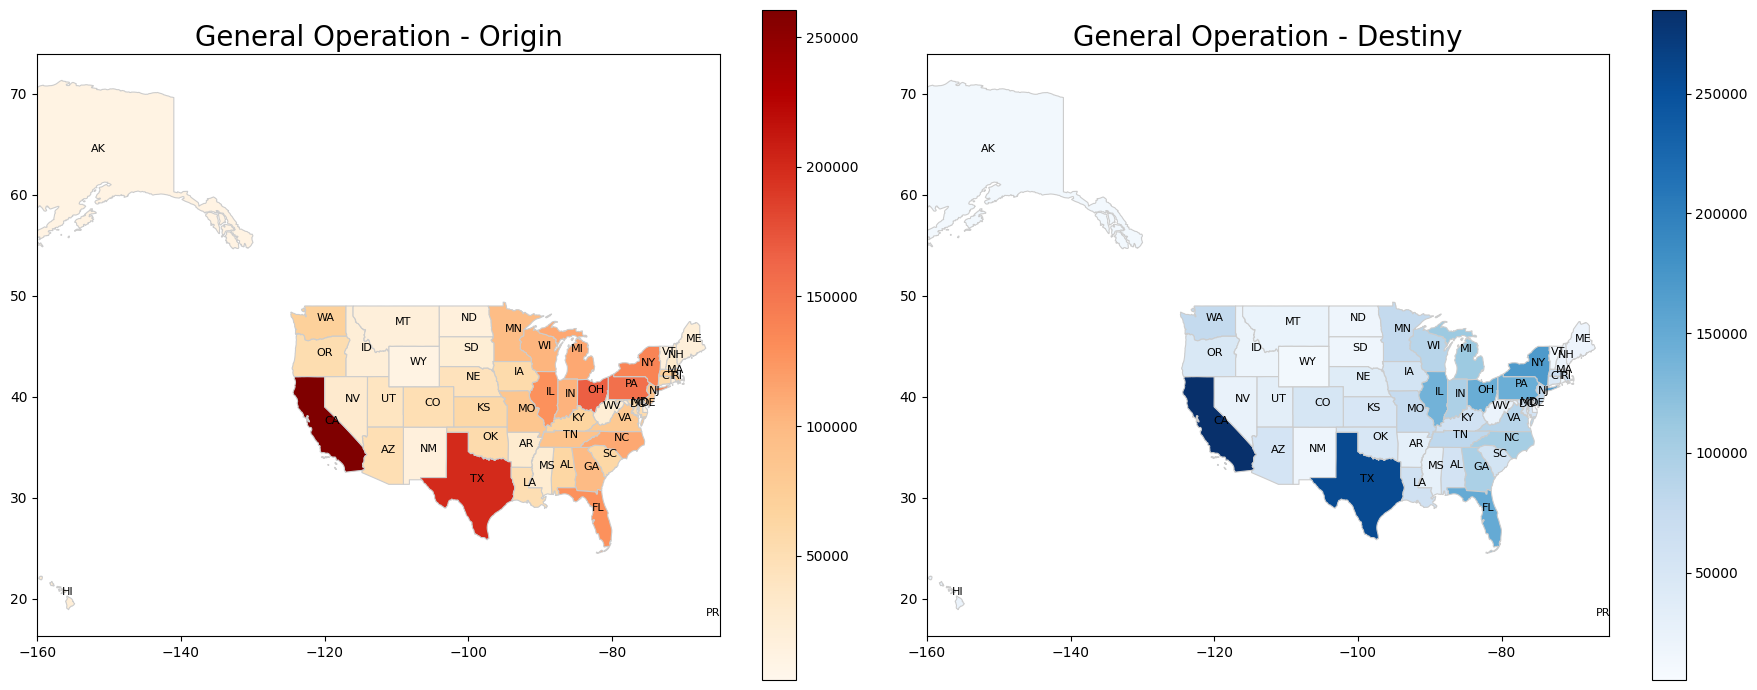

TOP 5 Origins: 


STATEFP   STATENS     AFFGEOID  GEOID STUSPS        NAME LSAD  \
12      06  01779778  0400000US06      6     CA  California   00   
11      48  01779801  0400000US48     48     TX       Texas   00   
21      36  01779796  0400000US36     36     NY    New York   00   
24      12  00294478  0400000US12     12     FL     Florida   00   
3       39  01085497  0400000US39     39     OH        Ohio   00   

           ALAND       AWATER  \
12  403503931312  20463871877   
11  676653171537  19006305260   
21  122049149763  19246994695   
24  138949136250  31361101223   
3   105828882568  10268850702   

                                             geometry  code       state  total  
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6  California 284963  
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48       Texas 257419  
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...    36    New York 169700  
24  MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ...    12     Florida 150346  
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...    39        Ohio 146734

TOP 5 DEST: 


STATEFP   STATENS     AFFGEOID  GEOID STUSPS          NAME LSAD  \
12      06  01779778  0400000US06      6     CA    California   00   
11      48  01779801  0400000US48     48     TX         Texas   00   
3       39  01085497  0400000US39     39     OH          Ohio   00   
4       42  01779798  0400000US42     42     PA  Pennsylvania   00   
21      36  01779796  0400000US36     36     NY      New York   00   

           ALAND       AWATER  \
12  403503931312  20463871877   
11  676653171537  19006305260   
3   105828882568  10268850702   
4   115884442321   3394589990   
21  122049149763  19246994695   

                                             geometry  code         state  \
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6    California   
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48         Texas   
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...    39          Ohio   
4   POLYGON ((-80.51989 40.90666, -80.51964 40.987...    42  Pennsylvania   
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...    36      New York   

    total  
12 260538  
11 199791  
3  166664  
4  154896  
21 139272

In [18]:
plotting_map(df_haz_1, shapes,'General Operation')

## Printing Operation for Hazardous Materials P

Text(0.5, 1.0, 'HAZMAT P per State')

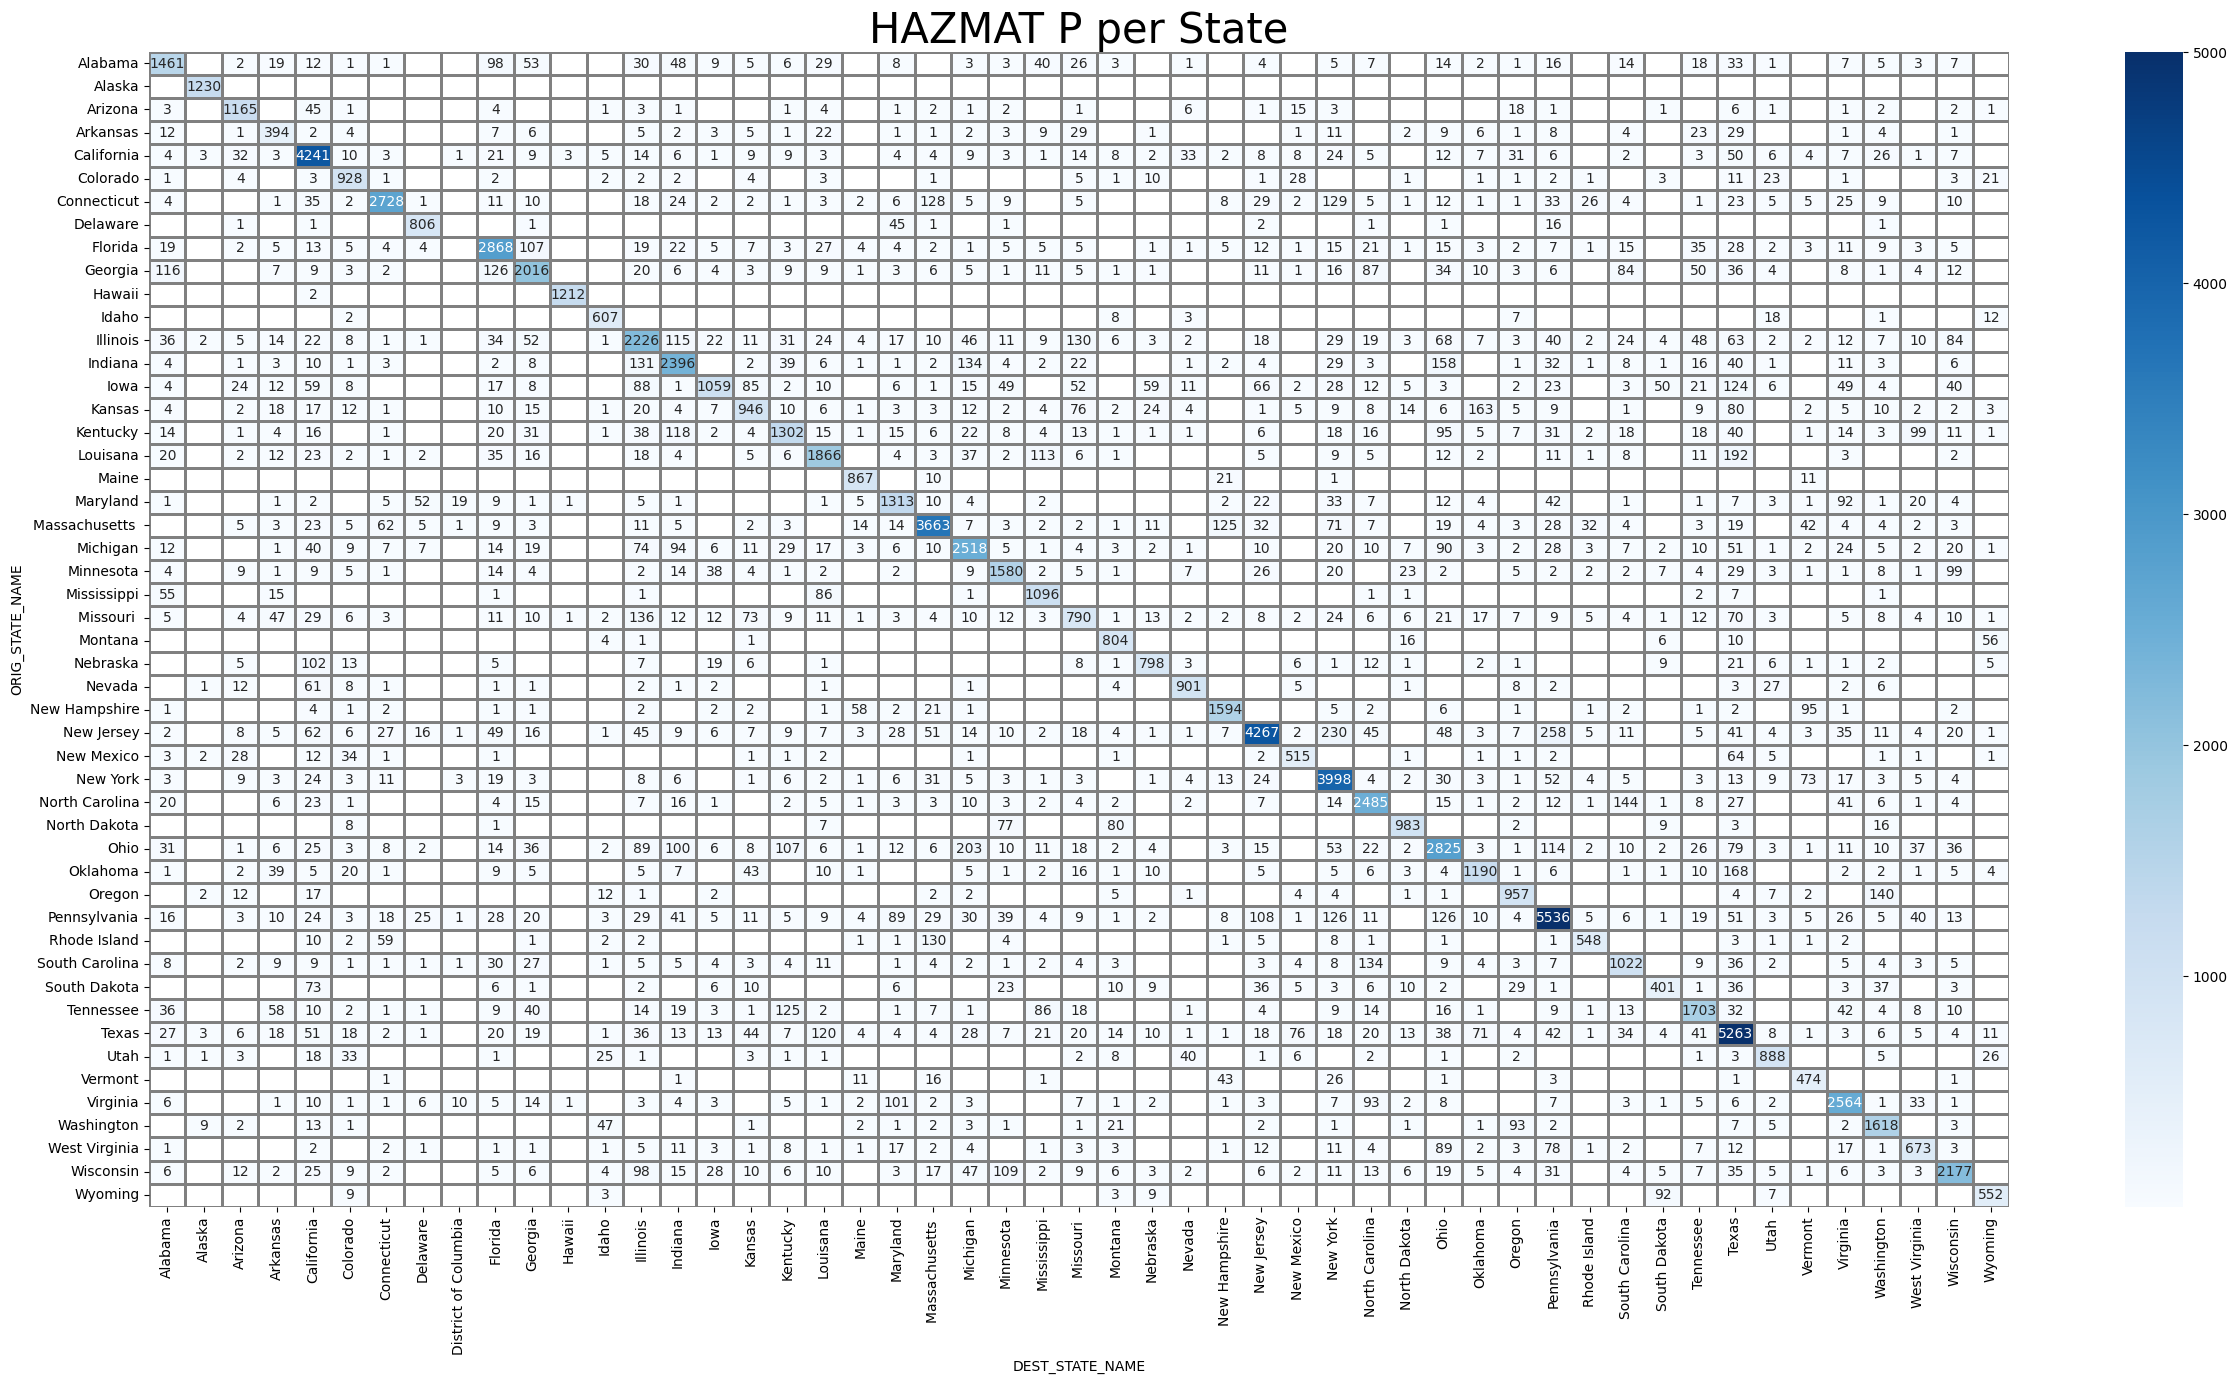

In [19]:

plt.figure(figsize=(30, 15))
sns.heatmap(df_haz_2.pivot_table(index='ORIG_STATE_NAME',values='train_idx', aggfunc='count', columns='DEST_STATE_NAME'), annot=True,  cmap='Blues', fmt='g', linecolor='grey',linewidths=1, vmax=5000)
plt.title('HAZMAT P per State', size=30)

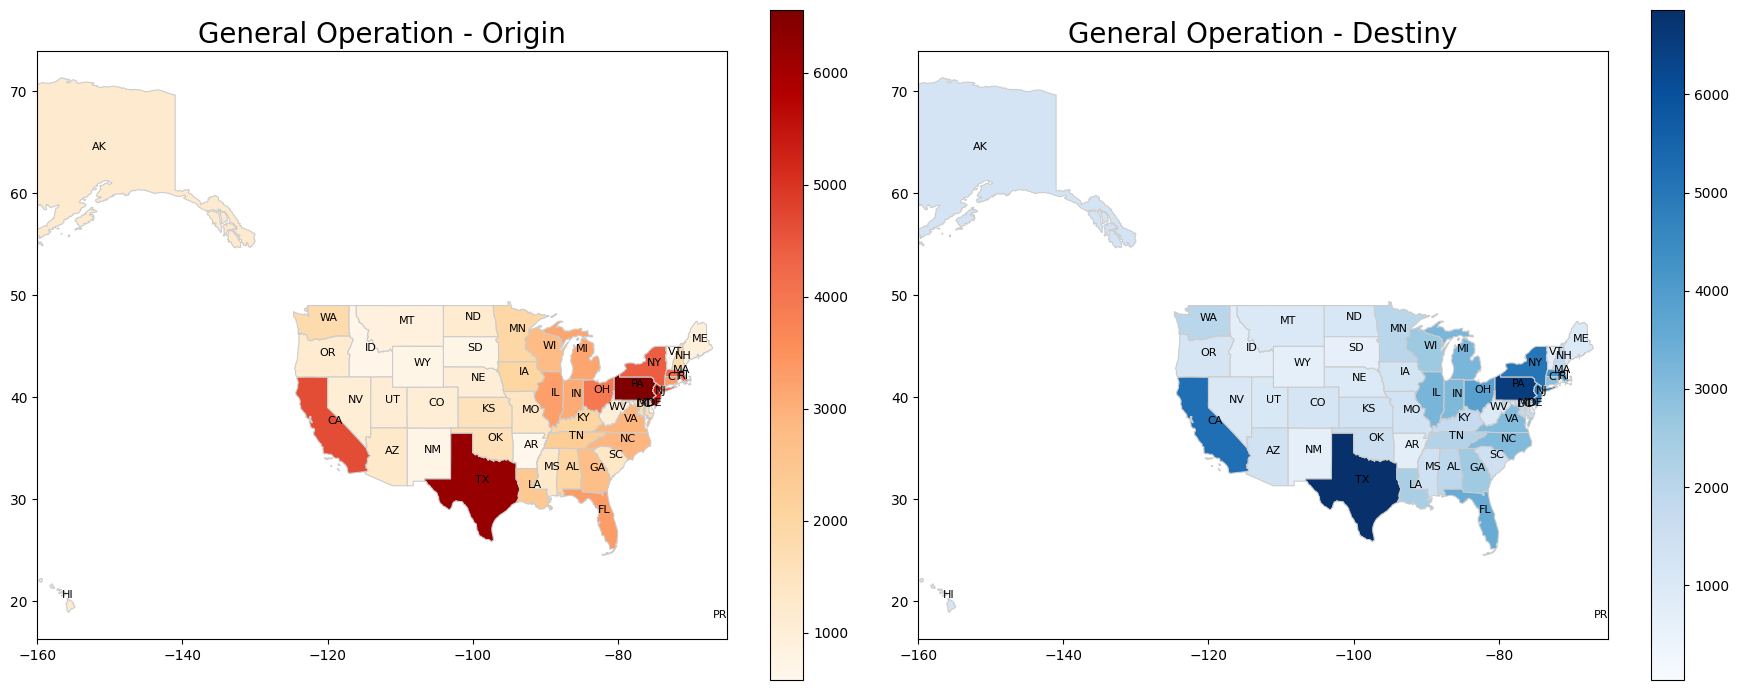

TOP 5 Origins: 


STATEFP   STATENS     AFFGEOID  GEOID STUSPS          NAME LSAD  \
11      48  01779801  0400000US48     48     TX         Texas   00   
4       42  01779798  0400000US42     42     PA  Pennsylvania   00   
12      06  01779778  0400000US06      6     CA    California   00   
21      36  01779796  0400000US36     36     NY      New York   00   
35      34  01779795  0400000US34     34     NJ    New Jersey   00   

           ALAND       AWATER  \
11  676653171537  19006305260   
4   115884442321   3394589990   
12  403503931312  20463871877   
21  122049149763  19246994695   
35   19047825980   3544860246   

                                             geometry  code         state  \
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48         Texas   
4   POLYGON ((-80.51989 40.90666, -80.51964 40.987...    42  Pennsylvania   
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6    California   
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...    36      New York   
35  POLYGON ((-75.55945 39.62981, -75.53514 39.647...    34    New Jersey   

    total  
11   6858  
4    6513  
12   5193  
21   5032  
35   4784

TOP 5 DEST: 


STATEFP   STATENS     AFFGEOID  GEOID STUSPS          NAME LSAD  \
4       42  01779798  0400000US42     42     PA  Pennsylvania   00   
11      48  01779801  0400000US48     48     TX         Texas   00   
35      34  01779795  0400000US34     34     NJ    New Jersey   00   
12      06  01779778  0400000US06      6     CA    California   00   
21      36  01779796  0400000US36     36     NY      New York   00   

           ALAND       AWATER  \
4   115884442321   3394589990   
11  676653171537  19006305260   
35   19047825980   3544860246   
12  403503931312  20463871877   
21  122049149763  19246994695   

                                             geometry  code         state  \
4   POLYGON ((-80.51989 40.90666, -80.51964 40.987...    42  Pennsylvania   
11  POLYGON ((-106.62345 31.91403, -106.63011 31.9...    48         Texas   
35  POLYGON ((-75.55945 39.62981, -75.53514 39.647...    34    New Jersey   
12  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     6    California   
21  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...    36      New York   

    total  
4    6561  
11   6194  
35   5414  
12   4663  
21   4416

In [20]:
plotting_map(df_haz_2, shapes,'General Operation')

## General Observations

As general observations, we can notice that:
* Our data is unbalanced, with more observations of HAZ Materials 1.
* Most of operation is interal (with same source and dest territory)
* For HAZMAT P, there is a correlation between Shpmt Value and Weight
* Texas and California are the states with more operation of the US.

-----------

Beyond the fact the geographical analysis was very insightful, we will move forward with the predictions, triying to not focus in those features, and try to make a good prediction only based on the quantitative features.

## Modelling

For modelling purposes, we will directly use our base raw data as train-test set, since the merge with shapes data was only for visualization purposes

In [21]:
df = pd.read_csv('/content/drive/MyDrive/02 - Challenge 2/00 - Data/supply_chain_train.csv')
real = pd.read_csv('/content/drive/MyDrive/02 - Challenge 2/00 - Data/supply_chain_test.csv')
#df = pd.read_csv('00 - Data/supply_chain_train.csv')
#real = pd.read_csv('00 - Data/supply_chain_test.csv')

In [22]:
df.head(1).transpose()

0
train_idx                  0
SHIPMT_ID             703837
ORIG_STATE                19
ORIG_MA                99999
ORIG_CFS_AREA       19-99999
DEST_STATE                19
DEST_MA                99999
DEST_CFS_AREA       19-99999
NAICS                    325
QUARTER                    2
SCTG                      04
MODE                       5
SHIPMT_VALUE            1868
SHIPMT_WGHT            67931
SHIPMT_DIST_GC           119
SHIPMT_DIST_ROUTED       162
TEMP_CNTL_YN               N
EXPORT_YN                  N
EXPORT_CNTRY               N
WGT_FACTOR               157
HAZMAT                     1

In [23]:
df.isnull().sum()

train_idx             0
SHIPMT_ID             0
ORIG_STATE            0
ORIG_MA               0
ORIG_CFS_AREA         0
DEST_STATE            0
DEST_MA               0
DEST_CFS_AREA         0
NAICS                 0
QUARTER               0
SCTG                  0
MODE                  0
SHIPMT_VALUE          0
SHIPMT_WGHT           0
SHIPMT_DIST_GC        0
SHIPMT_DIST_ROUTED    0
TEMP_CNTL_YN          0
EXPORT_YN             0
EXPORT_CNTRY          0
WGT_FACTOR            0
HAZMAT                0
dtype: int64

In [24]:
real.isnull().sum()

test_idx              0
SHIPMT_ID             0
ORIG_STATE            0
ORIG_MA               0
ORIG_CFS_AREA         0
DEST_STATE            0
DEST_MA               0
DEST_CFS_AREA         0
NAICS                 0
QUARTER               0
SCTG                  0
MODE                  0
SHIPMT_VALUE          0
SHIPMT_WGHT           0
SHIPMT_DIST_GC        0
SHIPMT_DIST_ROUTED    0
TEMP_CNTL_YN          0
EXPORT_YN             0
EXPORT_CNTRY          0
WGT_FACTOR            0
dtype: int64

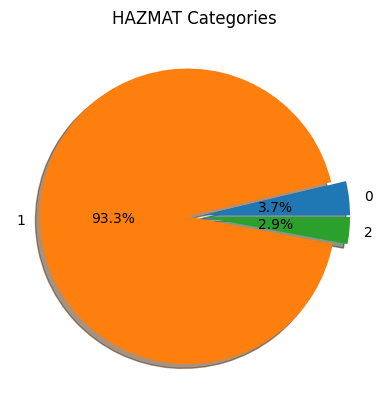

In [25]:
plt.title('HAZMAT Categories')
labels = list(df.groupby("HAZMAT")['HAZMAT'].count().keys())
plt.pie(x=df.groupby("HAZMAT")['HAZMAT'].count(),
        autopct="%.1f%%",  labels=labels, radius=1,pctdistance=0.5, explode=[0.05]*3, shadow=True);


As we can see, we have an unbalanced dataset, with most of observations from category 1. So in order to give enough information to our model, we will make an oversampling of the data

### TRAIN TEST Split

In [26]:
df['HAZMAT'] = df['HAZMAT'].astype('int64')


In [41]:
def prepare_data_no_categorical(df):
    aux = df.copy().drop(columns=['ORIG_STATE','ORIG_MA','ORIG_CFS_AREA','DEST_STATE','DEST_MA','DEST_CFS_AREA','SCTG','SHIPMT_ID'])
    aux['TEMP_CNTL_YN'] = aux['TEMP_CNTL_YN'].apply(lambda x: 0 if x=='N' else 1)
    aux['EXPORT_YN'] = aux['EXPORT_YN'].apply(lambda x: 0 if x=='N' else 1)
    aux['EXPORT_CNTRY'] = aux['EXPORT_CNTRY'].apply(lambda x: 0 if x=='N' else 1)
    try:
      aux.set_index('train_idx', inplace = True)
    except KeyError:
      aux.set_index('test_idx', inplace = True)
    finally:
      return aux

In [28]:
df_nocategorical = prepare_data_no_categorical(df)

In [29]:
df_nocategorical.head(2)

NAICS  QUARTER  MODE  SHIPMT_VALUE  SHIPMT_WGHT  SHIPMT_DIST_GC  \
train_idx                                                                    
0            325        2     5          1868        67931             119   
1            212        1     5           302        32638              17   

           SHIPMT_DIST_ROUTED  TEMP_CNTL_YN  EXPORT_YN  EXPORT_CNTRY  \
train_idx                                                              
0                         162             0          0             0   
1                          21             0          0             0   

           WGT_FACTOR  HAZMAT  
train_idx                      
0                 157       1  
1                  54       1

In [30]:
# train, test split

X = df_nocategorical.drop(columns=['HAZMAT'])
y = df_nocategorical.HAZMAT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
y_train.value_counts()/y_train.count()*100

1   93
0    4
2    3
Name: HAZMAT, dtype: float64

## Oversampling & Standarization of features

In [32]:
oversampler=RandomOverSampler();

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('training set:')
print(y_train_os.value_counts())

print('\nValidation set:')
print(y_test.value_counts())

training set:
1    2716438
2    2716438
0    2716438
Name: HAZMAT, dtype: int64

Validation set:
1    679359
0     27222
2     21045
Name: HAZMAT, dtype: int64


In [33]:
scaler = preprocessing.StandardScaler().fit(X_train_os)

In [34]:
X_scaled_os = scaler.transform(X_train_os)

In [35]:
X_scaled_test = scaler.transform(X_test)

------------------------
## Logistic Regression with lbfgs

In [ ]:
modelLR = LogisticRegression(multi_class='multinomial', solver='lbfgs')


In [ ]:
modelLR.fit(X_scaled_os,y_train_os)


LogisticRegression(multi_class='multinomial')

In [ ]:
yhat_train = modelLR.predict(X_scaled_os)

In [ ]:
print(classification_report(y_train_os, yhat_train))

              precision    recall  f1-score   support

           0       0.59      0.13      0.22   2716438
           1       0.62      0.44      0.51   2716438
           2       0.42      0.86      0.56   2716438

    accuracy                           0.48   8149314
   macro avg       0.54      0.48      0.43   8149314
weighted avg       0.54      0.48      0.43   8149314



In [ ]:
yhat_test = modelLR.predict(X_scaled_test)

In [ ]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.07      0.13      0.09     27222
           1       0.98      0.44      0.60    679359
           2       0.05      0.86      0.09     21045

    accuracy                           0.44    727626
   macro avg       0.36      0.48      0.26    727626
weighted avg       0.92      0.44      0.57    727626



# Logistic Regression - SAGA

In [ ]:
modelLRSAGA = LogisticRegression(multi_class='multinomial', solver='saga', C = 1)

In [ ]:
modelLRSAGA.fit(X_scaled_os,y_train_os)

LogisticRegression(C=1, multi_class='multinomial', solver='saga')

In [ ]:
yhat_trainSAGA = modelLRSAGA.predict(X_scaled_os)
print(classification_report(y_train_os, yhat_trainSAGA))

              precision    recall  f1-score   support

           0       0.59      0.13      0.22   2716438
           1       0.62      0.44      0.51   2716438
           2       0.42      0.86      0.56   2716438

    accuracy                           0.48   8149314
   macro avg       0.54      0.48      0.43   8149314
weighted avg       0.54      0.48      0.43   8149314



In [ ]:
yhat_testSAGA = modelLRSAGA.predict(X_scaled_test)
print(classification_report(y_test, yhat_testSAGA))


              precision    recall  f1-score   support

           0       0.07      0.13      0.09     27222
           1       0.98      0.44      0.60    679359
           2       0.05      0.86      0.09     21045

    accuracy                           0.44    727626
   macro avg       0.36      0.48      0.26    727626
weighted avg       0.92      0.44      0.57    727626



-----------------------
## LGBMClassifier

In [ ]:
model_lgb = lgb.LGBMClassifier()

In [ ]:
model_lgb.fit(X_scaled_os,y_train_os)

LGBMClassifier()

In [ ]:
yhat_test_lgb = model_lgb.predict(X_scaled_test)

In [ ]:
print(classification_report(y_test, yhat_test_lgb))

              precision    recall  f1-score   support

           0       0.37      0.76      0.50     27222
           1       0.99      0.91      0.95    679359
           2       0.32      0.81      0.46     21045

    accuracy                           0.90    727626
   macro avg       0.56      0.83      0.63    727626
weighted avg       0.95      0.90      0.92    727626



## ADA Boost Classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1)

modelADA = AdaBoostClassifier(base_estimator=dt,random_state=1)

In [37]:
modelADA.fit(X_scaled_os,y_train_os)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                   random_state=1)

In [38]:
pred_ab = modelADA.predict(X_scaled_test)
print(classification_report(y_test, pred_ab))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72     27222
           1       0.99      0.99      0.99    679359
           2       0.73      0.73      0.73     21045

    accuracy                           0.97    727626
   macro avg       0.81      0.81      0.81    727626
weighted avg       0.97      0.97      0.97    727626



# Predictions over the Real Data

In [40]:
real.head(2)

test_idx  SHIPMT_ID  ORIG_STATE  ORIG_MA ORIG_CFS_AREA  DEST_STATE  \
0         0     597127          55    99999      55-99999          31   
1         1    3513190          13    99999      13-99999          48   

   DEST_MA DEST_CFS_AREA  NAICS  QUARTER SCTG  MODE  SHIPMT_VALUE  \
0    99999      31-99999   4236        1   35    14          1194   
1    41700      48-41700   4541        1   30    14            70   

   SHIPMT_WGHT  SHIPMT_DIST_GC  SHIPMT_DIST_ROUTED TEMP_CNTL_YN EXPORT_YN  \
0           12             583                 744            N         N   
1            2             844                 937            N         N   

  EXPORT_CNTRY  WGT_FACTOR  
0            N        3100  
1            N        1239

In [42]:
real_NC = prepare_data_no_categorical(real)

In [43]:
real_NC.head(2)

NAICS  QUARTER  MODE  SHIPMT_VALUE  SHIPMT_WGHT  SHIPMT_DIST_GC  \
test_idx                                                                    
0          4236        1    14          1194           12             583   
1          4541        1    14            70            2             844   

          SHIPMT_DIST_ROUTED  TEMP_CNTL_YN  EXPORT_YN  EXPORT_CNTRY  \
test_idx                                                              
0                        744             0          0             0   
1                        937             0          0             0   

          WGT_FACTOR  
test_idx              
0               3100  
1               1239

In [44]:
scaled_real = scaler.transform(real_NC)

In [45]:
predictions = modelADA.predict(scaled_real)

In [46]:
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [49]:
indexes = real_NC.index.values

In [60]:
d = {}
for A, B in zip(indexes, predictions):
    key = str(A)
    d[key] = int(B)

In [61]:
# Initialize the final output
output_dict = {"target": {}}
output_dict["target"] = d



In [62]:
import json

In [63]:
with open('predictions.json', 'w') as json_file:
    json.dump(output_dict, json_file, indent=4)

<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Thanks_banner.jpg/1200px-Thanks_banner.jpg">